# Resources

 This notebook uses the surv_nn environment
 
 Resources:
 
 Youtube Videos:
  - https://www.youtube.com/watch?v=G5Q-JuVzFE0
  - https://www.youtube.com/watch?v=-vmV4qA0ztQ
  - https://www.youtube.com/watch?v=VxjfI7vkjhU
 
Papers:
 - SurvNet: https://www.frontiersin.org/articles/10.3389/fonc.2020.588990/full#f2
 - DeepSurv: https://bmcmedresmethodol.biomedcentral.com/track/pdf/10.1186/s12874-018-0482-1.pdf
 - Cox-PASNet: https://bmcmedgenomics.biomedcentral.com/articles/10.1186/s12920-019-0624-2
 
Software:
 - https://github.com/havakv/pycox
 - https://github.com/jaredleekatzman/DeepSurv
 - https://pytorch.org/tutorials/
 - https://github.com/DataX-JieHao/Cox-PASNet

# PyCox
Recreating this introduction to pycox
 - https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb


In [100]:
import torch
import lifelines
import numpy as np
import torchtuples as tt 
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [54]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [55]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [56]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
cols_leave = ['x4', 'x5', 'x6', 'x7']

In [57]:
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

In [58]:
for row, scaler in standardize:
    df_train[row] = scaler.fit_transform(df_train[row])
    df_test[row] = scaler.transform(df_test[row])
    df_val[row] = scaler.transform(df_val[row])


In [69]:
x_train = df_train[cols_standardize + cols_leave].astype('float32').to_numpy()
x_test = df_test[cols_standardize + cols_leave].astype('float32').to_numpy()
x_val = df_val[cols_standardize + cols_leave].astype('float32').to_numpy()

## Label Transforms

In [70]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

## Model

In [84]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = torch.nn.Sequential(
    torch.nn.Linear(in_features, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.1),
    
     torch.nn.Linear(32, 32),
     torch.nn.ReLU(),
     torch.nn.BatchNorm1d(32),
     torch.nn.Dropout(0.1),
   
     torch.nn.Linear(32, out_features)
)

In [85]:
net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [86]:
model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)


In [87]:
batch_size = 256 #256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [88]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val) # , callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 2.8731,	val_loss: 2.7017
1:	[0s / 0s],		train_loss: 2.5565,	val_loss: 2.3727
2:	[0s / 0s],		train_loss: 2.2592,	val_loss: 2.0692
3:	[0s / 0s],		train_loss: 1.9764,	val_loss: 1.7769
4:	[0s / 0s],		train_loss: 1.7136,	val_loss: 1.5631
5:	[0s / 0s],		train_loss: 1.5196,	val_loss: 1.4343
6:	[0s / 0s],		train_loss: 1.4387,	val_loss: 1.3869
7:	[0s / 0s],		train_loss: 1.4022,	val_loss: 1.3768
8:	[0s / 0s],		train_loss: 1.3897,	val_loss: 1.3791
9:	[0s / 0s],		train_loss: 1.3650,	val_loss: 1.3868
10:	[0s / 0s],		train_loss: 1.3504,	val_loss: 1.3786
11:	[0s / 0s],		train_loss: 1.3370,	val_loss: 1.3702
12:	[0s / 0s],		train_loss: 1.3286,	val_loss: 1.3670
13:	[0s / 0s],		train_loss: 1.3295,	val_loss: 1.3632
14:	[0s / 0s],		train_loss: 1.3028,	val_loss: 1.3644
15:	[0s / 0s],		train_loss: 1.3035,	val_loss: 1.3640
16:	[0s / 0s],		train_loss: 1.2982,	val_loss: 1.3652
17:	[0s / 0s],		train_loss: 1.2936,	val_loss: 1.3662
18:	[0s / 0s],		train_loss: 1.2995,	val_loss: 1.3735
19:

<AxesSubplot:>

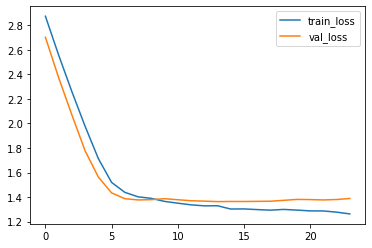

In [89]:
log.plot()

In [45]:
val

(            x0        x1        x2        x3        x8   x4   x5   x6   x7
 54   -0.384576 -0.893260 -0.742120  0.322306  0.277874  1.0  0.0  0.0  1.0
 146  -0.366509 -0.316730  0.053808 -1.036320  1.078160  0.0  1.0  0.0  1.0
 653  -0.565980 -0.831777 -0.983681  1.820763 -0.201838  1.0  1.0  1.0  1.0
 1028 -0.400674  0.986373  0.650860 -0.847255  0.798136  1.0  0.0  0.0  1.0
 526  -0.718365  1.075916  0.036073 -1.077208  0.733103  1.0  1.0  0.0  1.0
 ...        ...       ...       ...       ...       ...  ...  ...  ...  ...
 1837 -0.756493 -0.233845  0.380975 -0.399857  0.988644  1.0  1.0  0.0  1.0
 430  -0.573149  1.303744  0.337261 -0.611815  0.314598  0.0  0.0  0.0  1.0
 325  -0.530273  0.555719  0.246153 -0.753846  1.070508  1.0  0.0  0.0  1.0
 192  -0.831075  0.808999  0.569361  0.028037 -1.078633  0.0  0.0  0.0  1.0
 1808 -0.732841  0.426104 -0.100611 -0.550813  0.678017  1.0  0.0  0.0  1.0
 
 [305 rows x 9 columns],
 (array([3, 2, 4, 2, 5, 3, 1, 3, 4, 1, 5, 1, 5, 3, 2, 1, 5, 3

In [78]:
x_train.shape

(1218, 9)

# Prediction

In [90]:
surv = model.predict_surv_df(x_test)

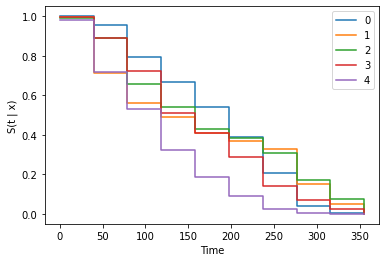

In [91]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [92]:
surv = model.interpolate(10).predict_surv_df(x_test)

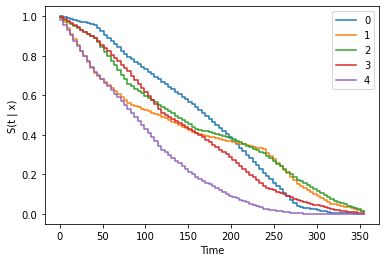

In [93]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [94]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [95]:
ev.concordance_td('antolini')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.664589427275425

In [98]:
EvalSurv?